In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules_enh.pickle', 'rb') as f:
    molecules = pickle.load(f)

In [4]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [5]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#labelled_enh.head(32)

In [6]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#unlabelled_enh.head(32)

In [7]:
len(labelled), len(labelled_enh)

(4658147, 4658147)

In [ ]:
from models import SKModel, partition_data

#data_df = labelled[labelled.type == '1JHC'].head(10)
data_df = labelled_enh.head(1000)
train_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df.copy()
        
model = SKModel(molecules=molecules,
                structures=structures)
model.setup_data(train_df, train_df)

In [ ]:
model.structures.columns

In [ ]:
list(model.input_df.columns)

In [ ]:
model.input_df.dtypes

In [ ]:
labelled_enh.head()

In [ ]:
import itertools

Training 25000 samples for 1JHC


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[1]	valid_0's l2: 334.119
[2]	valid_0's l2: 276.545
[3]	valid_0's l2: 229.947
[4]	valid_0's l2: 191.805
[5]	valid_0's l2: 160.632
[6]	valid_0's l2: 135.425
[7]	valid_0's l2: 114.796
[8]	valid_0's l2: 97.8822
[9]	valid_0's l2: 84.1594
[10]	valid_0's l2: 72.9598
[11]	valid_0's l2: 63.6583
[12]	valid_0's l2: 56.0357
[13]	valid_0's l2: 49.7548
[14]	valid_0's l2: 44.5767
[15]	valid_0's l2: 40.3535
[16]	valid_0's l2: 36.848
[17]	valid_0's l2: 33.9319
[18]	valid_0's l2: 31.5194
[19]	valid_0's l2: 29.5388
[20]	valid_0's l2: 27.8365
[21]	valid_0's l2: 26.3934
[22]	valid_0's l2: 25.2228
[23]	valid_0's l2: 24.0743
[24]	valid_0's l2: 23.2378
[25]	valid_0's l2: 22.41
[26]	valid_0's l2: 21.7328
[27]	valid_0's l2: 21.0213
[28]	valid_0's l2: 20.4849
[29]	valid_0's l2: 20.0584
[30]	valid_0's l2: 19.6039
[31]	valid_0's l2: 19.2262
[32]	valid_0's l2: 18.9084
[33]	valid_0's l2: 18.6151
[34]	valid_0's l2: 18.3003
[35]	valid_0's l2: 18.0373
[36]	valid_0's l2: 17.8597
[37]	valid_0's l2: 17.671
[38]	valid_0's

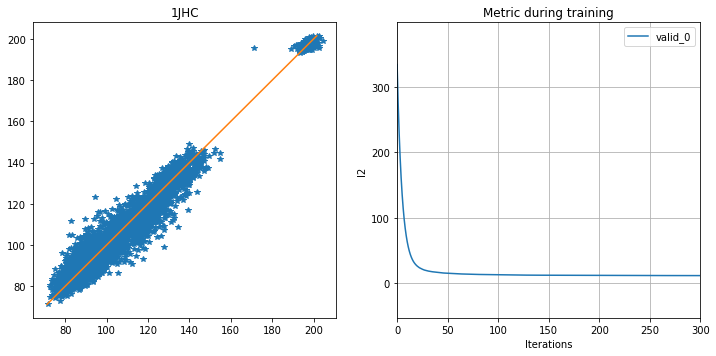

In [18]:
from models import LGBModel
from models import partition_data

# atom_count_ranges = [(1, 10), (11, 15), (16, 20), (21, 25), (26, 30)]
# C_count_ranges = [(1, 5), (6, 6), (7, 7), (8, 9)]
coupling_types = sorted(labelled_enh.type.unique())[0:1]
def test(data, count=5000):
    global model
    
    plt.figure(figsize=(25, 25))
#     for i, (t, (min_atoms, max_atoms)) in enumerate(itertools.product(coupling_types, C_count_ranges), 1):
    for i, t in enumerate(coupling_types, 1):    
#         data_df = data[(data.type == t) & (data.nC >= min_atoms) & (data.nC <= max_atoms)]
        data_df = data[data.type == t].head(count)

        train_df, valid_df, test_df = partition_data(data_df)
        
        if len(train_df) < 10 or len(test_df) < 10:
            continue
            
        print(f'Training {len(train_df)} samples for {t}')

        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(n_jobs=8,
                              max_depth=16,
                              boosting_type='gbdt',
                              num_leaves=65536, #128,
                              min_child_samples=20,
                              min_data_in_leaf=100,
                              learning_rate=0.1,
                              n_estimators=1000,
                              reg_alpha=0.1,
                              reg_lambda=0.3,
                              subsample_freq = 1,
                              subsample = 0.9,
                              num_iterations=300,
#                               verbose=500
                             ))
  

        model.fit(train_df, train_df, valid_df, valid_df)
        output, score = model.evaluate(test_df, test_df)
        
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')
        plt.subplot(4, 4, 2 * i - 1)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())
        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
        
        ax = plt.subplot(4, 4, 2 * i)
        model.plot_metric(ax=ax)
    plt.show()
        
test(labelled_enh, 50000)


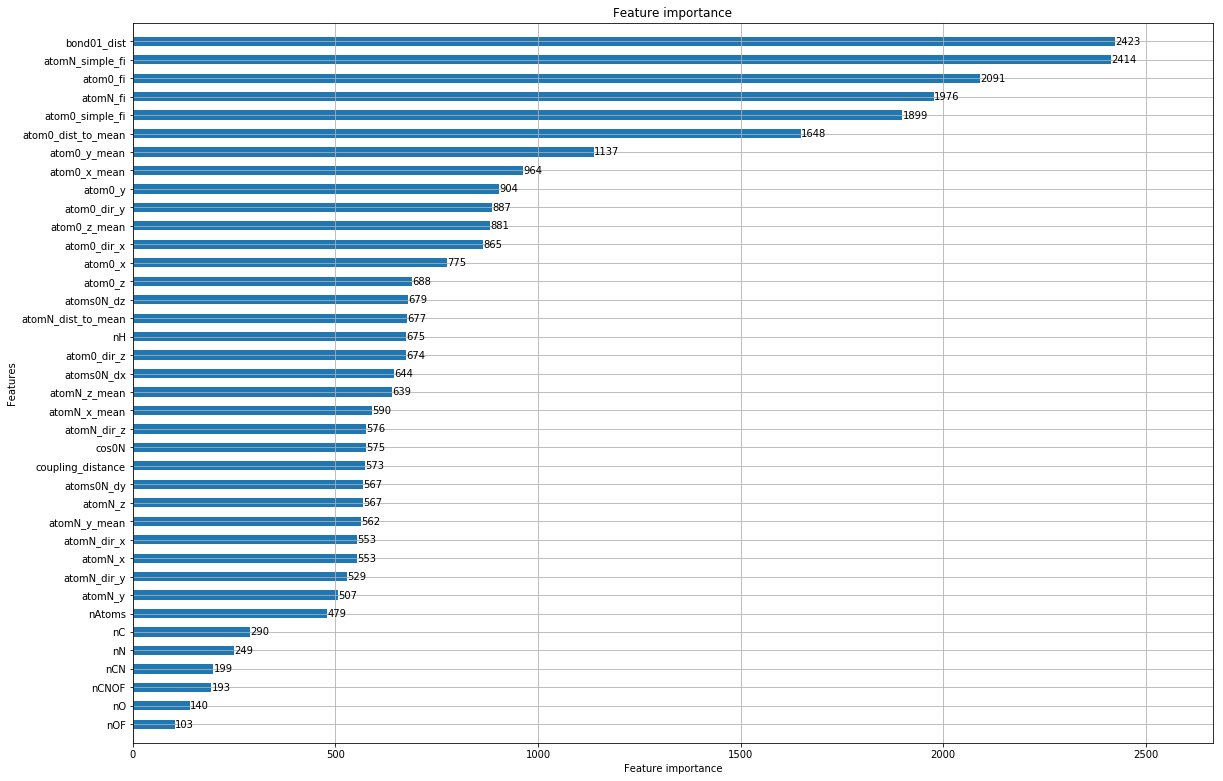

In [19]:
from models import LGBModel
fig = plt.figure(figsize=(15, 10))
model.plot_importance(ax=fig.add_axes([0, 0, 1, 1]), height=0.5)
plt.show()

In [ ]:
def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         dict(n_jobs=8,
                              max_depth=9,
                              boosting_type='gbdt',
                              num_leaves=128,
                              min_child_samples=20,
                              learning_rate=0.2,
                              n_estimators=1000,
                              reg_alpha=0.1,
                              reg_lambda=0.3,
                              subsample_freq = 1,
                              subsample = 0.9))
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

models = train(labelled_enh)

In [ ]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#%prun -s cumulative f(unlabelled.head(10000))
prediction = predict(unlabelled_enh, models)

In [ ]:
prediction.head()

In [ ]:
prediction.to_csv('../data/pred.csv',index=False)